In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
import keras


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.6.2


In [2]:
base_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

Working Directory Contents: ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']


In [3]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [4]:
train_data, train_labels = next(train_data_gen)
train_data.shape, train_labels.shape

((6400, 176, 176, 3), (6400, 4))

In [5]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, valid_data, train_labels, valid_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [8]:
densenet_model = DenseNet121(input_shape=(176, 176, 3), 
                             include_top=False,
                             weights="imagenet")

for layer in densenet_model.layers:
    layer.trainable=False

In [9]:
model = Sequential([
        densenet_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "DenseNet121")

In [10]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [11]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4),
           tf.keras.metrics.Recall(name='recall')]

CALLBACKS = [my_callback, rop_callback]
    
model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

model.summary()

Model: "DenseNet121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 5, 5, 1024)        7037504   
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               

In [12]:
%%time
#Fit the training data to the model and validate it using the validation data
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(valid_data, valid_labels), callbacks=CALLBACKS, epochs=EPOCHS)

2022-04-11 15:58:33.027845: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3045064704 exceeds 10% of free system memory.
2022-04-11 15:58:36.050593: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3045064704 exceeds 10% of free system memory.
2022-04-11 15:58:38.287102: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-11 15:58:46.438281: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


256/256 [==============================] - ETA: 0s - loss: 1.3180 - acc: 0.4304 - auc: 0.7034 - f1_score: 0.4278 - recall: 0.2927

2022-04-11 15:59:03.406631: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 761266176 exceeds 10% of free system memory.
2022-04-11 15:59:04.242315: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 761266176 exceeds 10% of free system memory.


256/256 [==============================] - 31s 69ms/step - loss: 1.3180 - acc: 0.4304 - auc: 0.7034 - f1_score: 0.4278 - recall: 0.2927 - val_loss: 0.7683 - val_acc: 0.6284 - val_auc: 0.8883 - val_f1_score: 0.6083 - val_recall: 0.4668
Epoch 2/50
256/256 [==============================] - 17s 65ms/step - loss: 0.8675 - acc: 0.6038 - auc: 0.8637 - f1_score: 0.5991 - recall: 0.4570 - val_loss: 0.6334 - val_acc: 0.6890 - val_auc: 0.9227 - val_f1_score: 0.6780 - val_recall: 0.5425
Epoch 3/50
256/256 [==============================] - 14s 56ms/step - loss: 0.7528 - acc: 0.6617 - auc: 0.8976 - f1_score: 0.6596 - recall: 0.5188 - val_loss: 0.5613 - val_acc: 0.7334 - val_auc: 0.9413 - val_f1_score: 0.7328 - val_recall: 0.5815
Epoch 4/50
256/256 [==============================] - 14s 55ms/step - loss: 0.7008 - acc: 0.6913 - auc: 0.9119 - f1_score: 0.6899 - recall: 0.5549 - val_loss: 0.5194 - val_acc: 0.7573 - val_auc: 0.9506 - val_f1_score: 0.7582 - val_recall: 0.6665
Epoch 5/50
256/256 [=======

In [14]:
model.save("/kaggle/working/DenseNet121", save_format = 'h5')

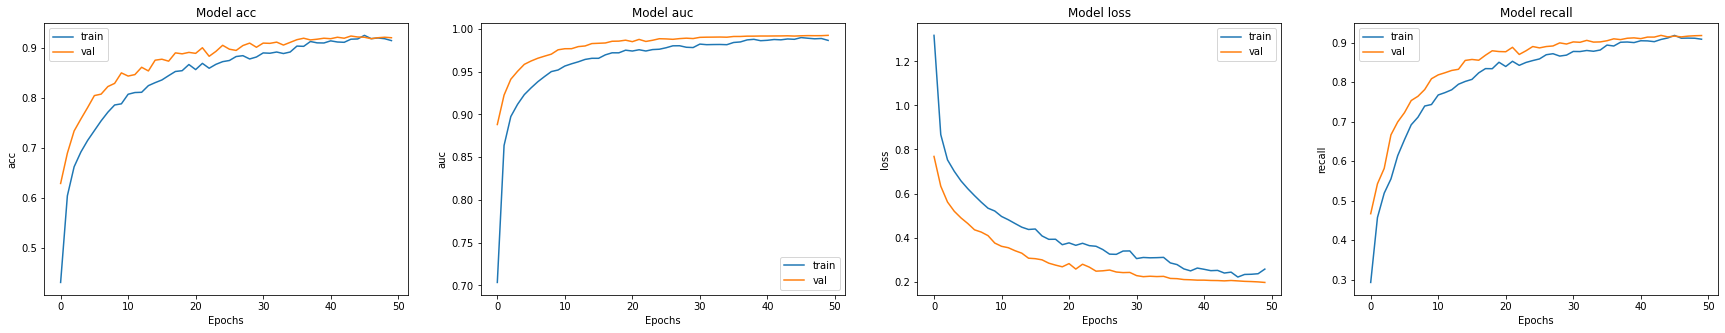

In [15]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 4, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss", "recall"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    
plt.savefig("/kaggle/working/DenseNetResults.png", bbox_inches ="tight", dpi=600)

In [16]:
d = {
    "Accuracy": history.history["acc"],
    "AUC": history.history["auc"],
    "Loss": history.history["loss"],
    "Recall": history.history["recall"],
    "Val Accuracy": history.history["val_acc"],
    "Val AUC": history.history["val_auc"],
    "Val Loss": history.history["val_loss"],
    "Val Recall": history.history["val_recall"]    
}

df = pd.DataFrame(d)
df.to_csv("/kaggle/working/densenet_results.csv", index=False)

In [20]:
np.save("train_data.npy", train_data)
np.save("train_labels.npy", train_labels)
np.save("valid_data.npy", valid_data)
np.save("valid_labels.npy", valid_labels)
np.save("test_data.npy", test_data)
np.save("test_labels.npy", test_labels)